## Comparison of Different Learning Algorithms on Blindness Prediction

- Histogram of Oriented Gradient (HOG) + SVM

- A basic CNN 

- InceptResNetV2 

In [ ]:
import pandas as pd
import numpy as np
import imageio 
import glob
import os
import scipy.ndimage as ndi
import matplotlib.pyplot as plt
import itertools
import pickle
import cv2

from PIL import Image
from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, accuracy_score
%matplotlib inline

### 1. HOG + SVM

In [3]:
feature_matrix=create_feature_matrix(train1)

In [65]:
ss = StandardScaler()
# run this on our feature matrix
test_stand = ss.fit_transform(feature_matrix)

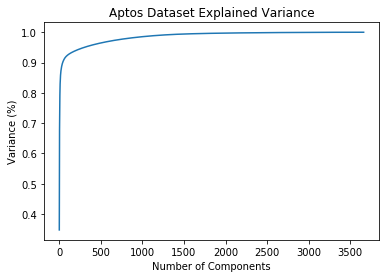

In [37]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(test_stand)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Aptos Dataset Explained Variance')
plt.show()

The plot above tells that selecting 1500 components can preserve around 98.8% or 99.9% of the total variance of the data. 

In [66]:
pca_1500 = PCA(n_components=1500)
# use fit_transform to run PCA on our standardized matrix
feature_pca_1500 = pca_1500.fit_transform(test_stand)
# look at new shape
print('PCA matrix shape is: ', feature_pca_1500)

PCA matrix shape is:  [[-2.09236458e+02 -5.17756461e+01 -3.20704674e+01 ...  9.02727983e-01
   2.31636744e-01  3.98585502e-01]
 [-9.27403098e+01 -6.14151140e+01  1.68314614e+02 ...  2.73418683e-01
  -9.93993733e-01 -3.94450037e-01]
 [-1.17356519e+02 -7.75872399e+01  3.14392747e+01 ...  3.02867679e-01
  -2.36495905e-01  1.22937930e-01]
 ...
 [-1.09504352e+02 -1.12457768e+02  1.48333412e+02 ...  3.98347820e-01
  -1.15526115e+00  2.96239636e+00]
 [ 4.28457390e+02  8.18648398e+01 -4.77580388e+01 ... -8.19217474e-02
  -4.06297312e-01  1.03302922e-01]
 [-2.82840975e+02 -5.99572368e+01 -2.87815702e+02 ...  3.80892579e-01
  -2.75057287e-01 -1.19599795e+00]]


In [117]:
# pca 1500
X_train, X_test, y_train, y_test = train_test_split(shuffle_df[feat_cols].values,
                                                    shuffle_df.diagnosis.values,
                                                    test_size=.3,
                                                    random_state=42)

#look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0    1264
2     688
1     261
4     208
3     142
dtype: int64

In [120]:
svm = SVC(kernel='linear', probability=True, random_state=42) ## pca 1500

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=42,
  shrinking=True, tol=0.001, verbose=False)

In [122]:
# pca 1500
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.6979071883530482


## 2. Keras

In [3]:
import keras
from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Input
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.activations import softmax, relu
from keras.optimizers import Adam, rmsprop, RMSprop, SGD
from keras.layers import BatchNormalization
import gc

Using TensorFlow backend.


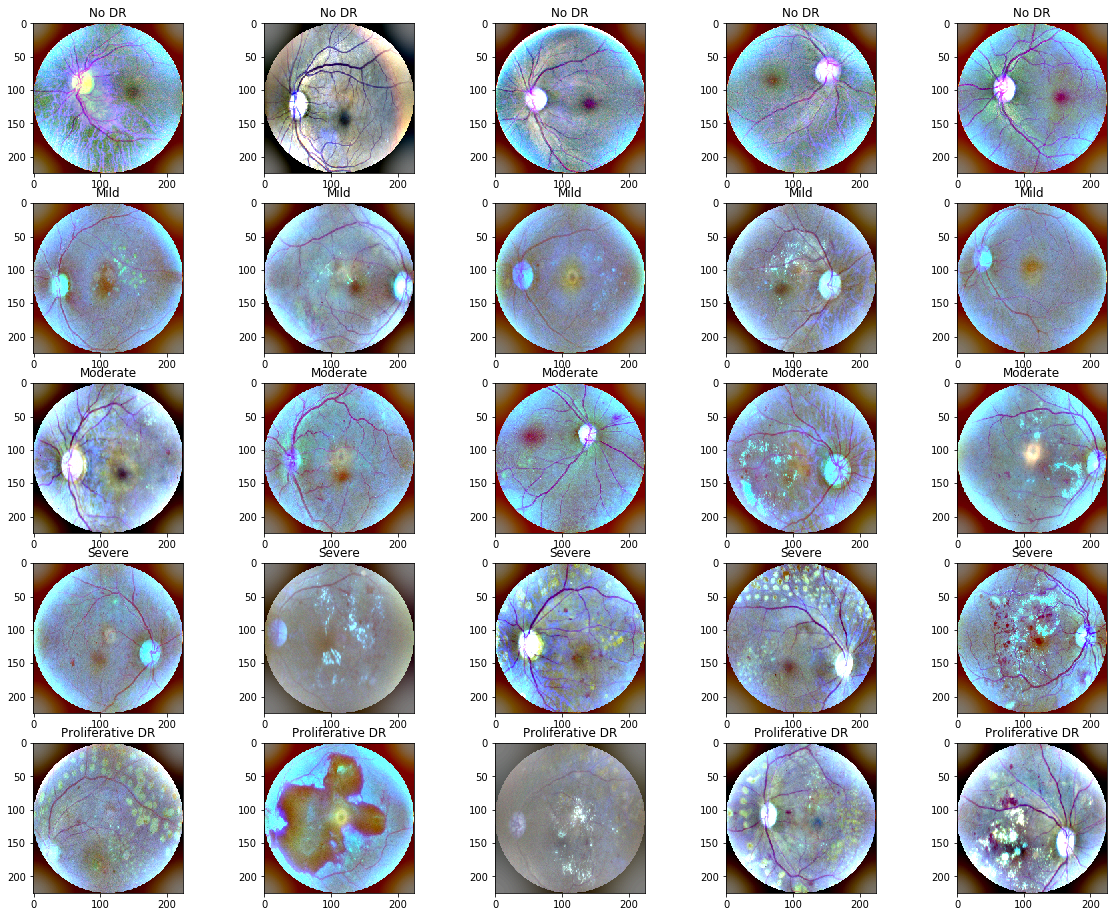

In [11]:
SEED=42
np.random.seed(SEED)
#set_random_seed(SEED)
Label= {0: "No DR", 1: "Mild", 2: "Moderate", 3: "Severe", 4: "Proliferative DR"}
# Display some random images from Data Set with class categories ing gray
figure = plt.figure(figsize=(20, 16))
for target_class in (train1['diagnosis'].unique()):
    for i, (idx, row) in enumerate(train1.loc[train1.diagnosis == target_class].sample(5, random_state=SEED).iterrows()):
        ax = figure.add_subplot(5, 5, target_class * 5 + i + 1)
        imagefile = f"../aptos/train_images/{idx}.png"  # if id_code is not the index, then, using '{row['id_code']}' instead of '{idx}'
        img=crop_circle_v2(imagefile)
        plt.imshow(img, cmap='gray')
        ax.set_title(Label[target_class])

In [72]:
train_df.id_code = train_df.id_code.apply(lambda x: x + ".png")
test_df.id_code = test_df.id_code.apply(lambda x: x + ".png")
train_df['diagnosis'] = train_df['diagnosis'].astype('str')

In [73]:
SEED=42
IMG_DIM =224  # 299
BATCH_SIZE=8

datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.2, horizontal_flip=True,
                                         vertical_flip=True, rotation_range=360, zoom_range=0.2, shear_range=0.1)

train_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory="../aptos/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    subset='training',
                                                    shuffle=True,
                                                    seed=SEED,
                                                    )

valid_generator = datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory="../aptos/train_images/",
                                                    x_col="id_code",
                                                    y_col="diagnosis",
                                                    batch_size=BATCH_SIZE,
                                                    class_mode="categorical",
                                                    subset='validation',
                                                    shuffle=True,
                                                    seed=SEED
                                                    )

gc.collect()

Found 2930 validated image filenames belonging to 5 classes.
Found 732 validated image filenames belonging to 5 classes.


In [36]:
IMG_DIM = 224
BATCH_SIZE = 8
CHANNEL_SIZE = 3
NUM_EPOCHS = 30
lr_rate = 0.001
n_classes = 5

# baseline model
def create_basemod():
    # create model
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=(3, 3), input_shape=(IMG_DIM, IMG_DIM, CHANNEL_SIZE), activation='relu'));
    model.add(MaxPooling2D(pool_size=(2, 2)));
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'));
    model.add(MaxPooling2D(pool_size=(2, 2)));
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'));
    model.add(MaxPooling2D(pool_size=(2, 2)));
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'));
    model.add(MaxPooling2D(pool_size=(2, 2)));
    model.add(Flatten());
    model.add(Dropout(rate=0.2));
    model.add(Dense(512, activation='relu', kernel_initializer='uniform'));
    model.add(Dropout(rate=0.5));
    model.add(Dense(n_classes, activation='softmax'))

    return model

model=create_basemod()

In [38]:
# model 1

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=3, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

model.compile(optimizer=RMSprop(), loss='categorical_crossentropy', metrics=['accuracy'])


NUM_EPOCHS=50
# train
history_callback = model.fit_generator(train_generator,
                      steps_per_epoch=ntrain//batch_size,
                      epochs=NUM_EPOCHS,
                      validation_data=valid_generator,
                      validation_steps=nvalid//batch_size, callbacks=[early_stop, reduce_lr])

Epoch 1/50
366/366 [==============================] - 97s 265ms/step - loss: 1.3415 - acc: 0.5044 - val_loss: 1.1546 - val_acc: 0.5959
Epoch 2/50
366/366 [==============================] - 105s 286ms/step - loss: 1.0760 - acc: 0.6318 - val_loss: 0.8866 - val_acc: 0.6952
Epoch 3/50
366/366 [==============================] - 107s 292ms/step - loss: 0.9943 - acc: 0.6677 - val_loss: 0.8737 - val_acc: 0.6910
Epoch 4/50
366/366 [==============================] - 103s 280ms/step - loss: 0.9690 - acc: 0.6749 - val_loss: 0.8771 - val_acc: 0.7090
Epoch 5/50
366/366 [==============================] - 102s 278ms/step - loss: 0.9711 - acc: 0.6800 - val_loss: 0.9064 - val_acc: 0.7186
Epoch 6/50
366/366 [==============================] - 101s 276ms/step - loss: 1.0252 - acc: 0.6523 - val_loss: 1.0962 - val_acc: 0.6979

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/50
366/366 [==============================] - 96s 263ms/step - loss: 0.8236 - acc: 0.7230 - val

In [27]:
history_callback.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

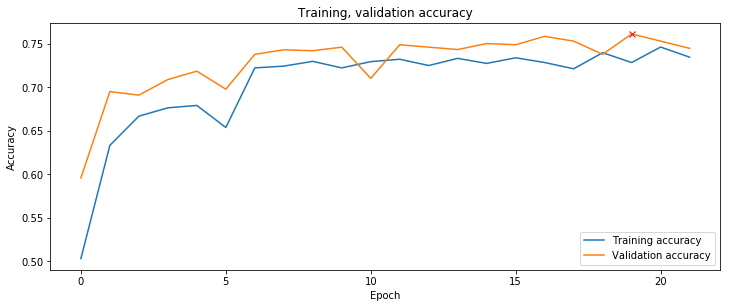

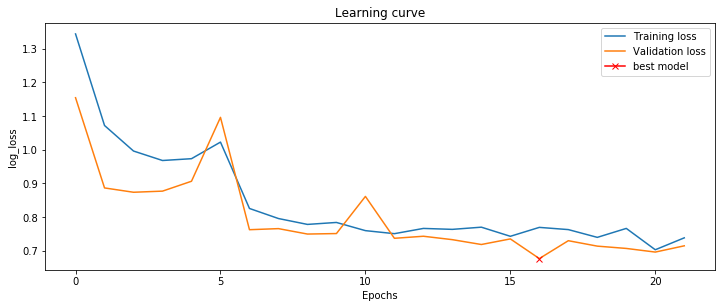

In [54]:
accu = history_callback.history['acc']
val_acc = history_callback.history['val_acc']

plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.title("Training, validation accuracy")
plt.plot(accu, label="Training accuracy")
plt.plot(val_acc, label="Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.plot(np.argmax(history_callback.history["val_acc"]), np.max(history_callback.history["val_acc"]), marker="x", color="r",
         label="best model")
plt.show()

plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 2)
plt.title("Learning curve")
plt.plot(history_callback.history["loss"], label="Training loss")
plt.plot(history_callback.history["val_loss"], label="Validation loss")
plt.plot(np.argmin(history_callback.history["val_loss"]), np.min(history_callback.history["val_loss"]), marker="x", color="r",
         label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.show()

The graphs above show that the model is not overfitting because the train and validation accuracy curves are close to each other and their loss curves appear to trend down closely as well. 

In [53]:
#from tqdm import tqdm
(eval_loss, eval_accuracy) = tqdm(model.evaluate_generator(generator=valid_generator, steps=nvalid//batch_size, pickle_safe=False))
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))
print("[INFO] Loss: {}".format(eval_loss))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(generator=<keras_pre..., steps=91, use_multiprocessing=False)`
  
100%|██████████| 2/2 [00:00<00:00, 14820.86it/s]

[INFO] accuracy: 75.03%
[INFO] Loss: 0.702163911194637


## 3. Transfer learning

In [ ]:
from keras.applications import InceptionResNetV2

conv_base=InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

model_ir=Sequential()
model_ir.add(conv_base)
model_ir.add(GlobalAveragePooling2D())
model_ir.add(Dense(1024, activation="relu"))
model_ir.add(Dropout(0.3))
model_ir.add(Dense(5, activation="softmax"))
             
conv_base.trainable=False

model_ir.compile(optimizer=RMSprop(lr=0.0001, decay=0.0001/35),loss='categorical_crossentropy',metrics=['accuracy'])

TRAIN_STEPS = train_generator.n // train_generator.batch_size
VALID_STEPS = valid_generator.n // valid_generator.batch_size

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3, verbose=1, mode='auto')
# Reducing the Learning Rate if result is not improving. 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', min_delta=0.0004, patience=2, factor=0.1, min_lr=1e-6, mode='auto',
                              verbose=1)

history_ir = model_ir.fit_generator(generator=train_generator,
                      steps_per_epoch=TRAIN_STEPS,
                      validation_data=valid_generator,
                      validation_steps=VALID_STEPS, callbacks=[early_stop, reduce_lr], 
                      verbose=1, 
                      #use_multiprocessing= True, workers = 2, 
                      epochs=35)

The accuracy is increased to 81% compared to the model created via a basic CNN. This suggests that transfer learning tends to create the best model with the highest accuracy.